# Quality Control: initial steps

> **Important notes for this notebook**
>
> After gathering your data and genotyping, there are many checks to do
> to determine the quality of the data. It is crucial to **perform
> quality control before** carrying out any GWAS, otherwise, there is
> the risk that some of the associations are spurious.
>
> ## Learning outcomes
>
> -   **Distinguish** the various QC steps
> -   **Discuss and choose** thresholds on plink
> -   **Implement** basic QC in `plink` and statistical plots in `R`
> -   **Hypothesize** the effects of various `plink` commands and
>     **verify** your hypothesis using the analysis in `R`
>
> ## How to make this notebook work
>
> -   In this notebook, we will use both `R` and `bash command line`
>     programming languages. Remember to **change the kernel** whenever
>     you transition from one language to the other
>     (`Kernel --> Change Kernel`) indicated by the languages’ images.
>     We will first run `Bash` commands.
>
> <img src="Images/bash.png" alt="Bash" width="80"> Choose the Bash
> kernel

The next critical step in any GWAS involves **scrutinizing the data for
potential issues**. It’s crucial to ensure that the results are not
merely artifacts of poor data quality discovered after the analysis.

After gathering your data and genotyping, there are many checks one can
do to determine the quality of the data. PLINK provides several summary
statistics for quality control (e.g. missing genotype rate, minor allele
frequency, and Hardy-Weinberg equilibrium failures) which will serve as
thresholds for subsequent analyses.

For this tutorial, we will look at the following quality-related topics:

1.  Individual Missingness  
2.  Sex discrepancy  
3.  Minor Allele Frequency (MAF)  
4.  Hardy-Weinberg Equilibrium (HWE)  
5.  Heterozygosity Rate

# Individual and SNP Missingness

## Missingness per SNP

Overall, the SNP genotyping platform is very reliable and delivers
stable results when it comes to determining genotypes. Of course, it is
not flawless. One of the most frequent problems is that some of the SNPs
are just not well-genotyped in the entire population. These should be
removed to improve the overall data quality.

Certainly, we can’t remove every SNP with any missing values, as that
would result in losing a significant portion of our data. Instead, we
adopt some **thresholds**. However, determining these thresholds isn’t
governed by strict rules. You have the flexibility to set them within
“reasonable” limits. To find out what constitutes “reasonable,”
consulting relevant literature for your species of interest is
advisable. For humans, a common starting point is a threshold of 0.2,
meaning we exclude SNPs where 20% or more of the genotypes are missing
in our population.

## Missingness per individual

The reliability of SNP chips is also high when it comes to individual
genotypes. In some cases, however, some of the individuals contain a
large number of missing SNPs. The reason could be low DNA sample
quality, the wrong chip type used (e.g. cattle chip for deer samples),
or other technical issues. Regardless of the reason, you should remove
the worst offenders from your data set, to not compromise the overall
quality of your results.

> **Stop - Read - Solve**
>
> Have a look at the following toy example:
>
> | /    | SNP1 | SNP2 | SNP3 | SNP4 | SNP5 |
> |------|------|------|------|------|------|
> | IND1 | 22   | 00   | 11   | 12   | 22   |
> | IND2 | 22   | 00   | 11   | 12   | 22   |
> | IND3 | 11   | 12   | 11   | 22   | 21   |
> | IND4 | 00   | 00   | 11   | 11   | 00   |
> | IND5 | 22   | 00   | 11   | 22   | 22   |
>
> Here, we have a data set of five individuals, each of them genotyped
> for five SNPs. The genotypes themselves are in numerical coding, 11
> and 22 being the two homozygous, 12 the heterozygous, and 00 coded as
> missing. We want to apply two filters: one for the variants, and one
> for the individuals.
>
> -   First remove variants with \>= 40% missingness
> -   Then remove individuals with \>= 40% missingness
>
> Which variants and individuals are we removing?

In practice, you want to **remove the SNPs based on missingness before
the individuals**. This is simply because we generally have a lot more
SNPs than individuals, and would thus lose less information by removing
SNPs than individuals. This will remove “bad” SNPs first, leaving a
lower rate of missingness for all the individuals.

> **Solution**
>
> **Variant-level threshold**: In this example, we would only remove
> SNP2 since it exceeds this threshold, with 80% missingness (4 out of 5
> missing values).
>
> **Individual-level threshold**: IND4 is removed from the data set, as
> there is missing genotype information for 2/4 = 50% SNPs (after
> filtering out SNP2).

## First run of the PLINK tool

> **The plink syntax**
>
> Before using `plink`, let’s see how its syntax is. Usual PLINK
> commands are written in this basic form:
>
>     plink --bfile INPUT --out OUTPUT
>
> with the additional option `--make-bed` if you need to generate a
> modified version of the input data, such as in
>
>     plink --bfile INPUT --make-bed --out OUTPUT
>
> which will create an OUTPUT equal to the input, because you have no
> other options added.
>
> Note that **INPUT and OUTPUT have no extension**, as this will be
> added by `plink`. For example, INPUT means you have the files
> `INPUT.bim`, `INPUT.bed`, `INPUT.fam`, and eventually other extensions
> needed by extra options. The same holds for the OUTPUT. **The software
> always tells you which file extension has created and which it needs,
> in case it misses some files.**
>
> You will see how we add different options along the tutorials. Often
> we use the option `--silent` to avoid printing messages all the time.
> Feel free to remove it to know which files are created.

Using PLINK, we can address missing data using two functions; one
operates at the variant level and the other at the individual level:

-   `--geno`: This will remove SNPs with a specified proportion of
    missingness (e.g. `--geno 0.01` will remove SNPs above 1%
    missingness).
-   `--mind`: This will remove individuals with a specified proportion
    of missingness (e.g. `--mind 0.01` will remove individuals above 1%
    missingness).

A common threshold for –mind and –geno ranges from 1% to 5% to ensure
quality and robustness. Higher thresholds may be acceptable if the study
has a large sample size and missingness is not widespread.

Let’s implement our first QC method in PLINK.

<img src="Images/bash.png" alt="Bash" width="40"> We use `ln -sf` to
link the data folder and create a folder for output files
(`Results/GWAS3`)

In [4]:
ln -sf ../Data
mkdir -p Results/GWAS3

PLINK program uses options implemented using the `--` symbol to perform
different functions or access files. We will use the option `--bfile`
for data (filename without extension), `--missing` for missing data
summary, and `--out` for output prefixes. This helps us analyze data
missingness.

In [5]:
plink --bfile Data/HapMap_3_r3_1 --missing --out Results/GWAS3/data

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWAS3/data.log.
Options in effect:
  --bfile Data/HapMap_3_r3_1
  --missing
  --out Results/GWAS3/data

385567 MB RAM detected; reserving 192783 MB for main workspace.
1457897 variants loaded from .bim file.
165 people (80 males, 85 females) loaded from .fam.
112 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 112 founders and 53 nonfounders present.
Calculating allele frequencies... done.
commands treat these as missing.
Total genotyping rate is 0.997378.
--missing: Sample missing data report written to Results/GWAS3/data.imiss, and
variant-based missing data report written to Results/GWAS3/data.lmiss.

> **Stop - Read - Solve**
>
> PLINK prints a lot of information. Make sure you read it.
>
> 1.  Which file formats are read by PLINK to understand the data?
> 2.  What is the percentage of valid genotype data?
> 3.  What is the count of females and males? Is sex information
>     available for all individuals?
> 4.  What files are generated as output from the command?

> **Solution**
>
> 1.  PLINK reads two files in the format *.fam* and *.bim* for this
>     task. As explained in the notebook GWAS2, these files contain data
>     for individuals and variants, respectively.
> 2.  Immediately we can see that the total genotyping rate for our
>     sample is 0.997378.
> 3.  It counts 80 males and 85 females.
> 4.  It prints the name of the two output files from this command:
>     `data.imiss` and `data.lmiss`, in the directory `Results/GWAS3/`.
>     These files show the proportion of **missing SNPs per individual**
>     and the proportion of **missing individuals per SNP**,
>     respectively.

These files include a header and one line per sample or per variant,
containing the following fields:

-   `FID`: Family ID
-   `IID`: Within-family ID
-   `CHR` and SNP: chromosome and SNP ID.
-   `MISS_PHENO`: Indicates if the phenotype is missing (Y/N)
-   `N_MISS`: Number of missing genotype calls (excluding obligatory
    missings or heterozygous haploids)
-   `N_GENO`: Number of potentially valid calls
-   `F_MISS`: Missing call rate

Let’s check the first 5 lines of the files to understand their
structure.

-   **Are there missing phenotypes or genotypes in the `.imiss` file?**

In [6]:
head -5 Results/GWAS3/data.imiss

    FID       IID MISS_PHENO   N_MISS   N_GENO   F_MISS
   1328   NA06989          N     4203  1457897 0.002883
   1377   NA11891          N    20787  1457897  0.01426
   1349   NA11843          N     1564  1457897 0.001073
   1330   NA12341          N     6218  1457897 0.004265

No, the first individuals of the `imiss` file do not seem to miss
phenotypes (column `MISS_PHENO`) and have small proportion of missing
genotypes (column `F_MISS`).

-   **What about at the variant-level (`.lmiss`)?**

In [7]:
head -5 Results/GWAS3/data.lmiss

 CHR         SNP   N_MISS   N_GENO   F_MISS
   1   rs2185539        0      165        0
   1  rs11510103        4      165  0.02424
   1  rs11240767        0      165        0
   1   rs3131972        0      165        0

In the `lmiss` file, we can see that the second variant has missing data
(4 missing genotype calls).

<img src="Images/R.png" alt="R" width="40"> Switch to the R kernel.

We can visualize the distribution of missing data in individuals and
SNPs using histograms in `R` (change kernel).

The `ggplot2` package is used here for visualization and various plot
elements are combined with the `+` symbol. Histograms are saved in your
results directory as `histimiss.png` and `histlmiss.png`. Look below at
the `R` code and the output.

In [ ]:
suppressWarnings(library(ggplot2))
options(repr.plot.width = 9, repr.plot.height = 4)

# Read data into R 
indmiss <- read.table(file="Results/GWAS3/data.imiss", header=TRUE)
snpmiss <- read.table(file="Results/GWAS3/data.lmiss", header=TRUE)

#lmiss histogram
hist.lmiss <- ggplot(snpmiss, aes(x=snpmiss[,5])) +
    geom_histogram(binwidth = 0.005, col = "black", fill="tomato") + 
    labs(title = "Frequency of missingness rates in SNPs") + 
    xlab("Frequency") + 
    ylab("Missingness in SNPs") + 
    theme_bw() +
    theme(axis.title=element_text(size=13), axis.text=element_text(size=13), plot.title=element_text(size=15))


#imiss histogram
hist.imiss <- ggplot(indmiss, aes(x=indmiss[,6])) +
    geom_histogram(binwidth = 0.001, col = "black", fill="tomato") + 
    labs(title = "Frequency of missingness rates in individuals") + 
    xlab("Frequency") + 
    ylab("Missingness in Individuals") + 
    theme_bw() +
    theme(axis.title=element_text(size=13), axis.text=element_text(size=13), plot.title=element_text(size=15))

#show histograms
show(hist.lmiss)
show(hist.imiss)

# Save plots silently
suppressMessages({
ggsave(plot=hist.lmiss, filename="Results/GWAS3/histlmiss.png");
ggsave(plot=hist.imiss, filename="Results/GWAS3/histimiss.png");
})

> **Stop - Read - Solve**
>
> -   What is the highest percentage of missingness for a SNP?
> -   Are there individuals with no missing data?

> **Solution**
>
> Here are a few observations we can make. Firstly, it’s clear that very
> few individuals have no missing data at all. One interpretation could
> be that one or a few SNPs are poorly genotyped across all samples.
> Fortunately, this isn’t the case here, otherwise the first plot would
> show many more SNPs with high missing frequency. As shown in the
> SNP-based histogram, the highest percentage of missing data for a SNP
> is around 0.05 (5%). Overall, **the histogram provides insight into
> how applying a missingness filter will affect the size of your
> remaining data**.

<img src="Images/bash.png" alt="Bash" width="40"> Switch to the Bash
kernel.

Next, we will use PLINK to filter the data using missingness thresholds
to ensure data quality.

We choose a 2% missingness threshold for both individuals and SNP, as
only a few outliers exceed this rate (this threshold does not need to be
the same for SNPs and individuals). Below, we provide the command to
remove samples (`--mind`) and SNPs (`--geno`) above this threshold. The
`--out` option defines the output prefix, and `--make-bed` denotes the
output format (consisting of the three files `.bed`, `.bim`, `.fam`).

PLINK provides detailed output during execution, so check the printed
text to monitor progress.

In [2]:
# Delete samples with missing call freq > 2% and SNPs with missingness > 2%
plink --bfile Data/HapMap_3_r3_1 \
    --geno .02 \
    --make-bed \
    --out Results/GWAS3/HapMap_geno

plink --bfile Results/GWAS3/HapMap_geno \
    --mind .02 \
    --make-bed \
    --out Results/GWAS3/HapMap_3_r3_2

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWAS3/HapMap_geno.log.
Options in effect:
  --bfile Data/HapMap_3_r3_1
  --geno .02
  --make-bed
  --out Results/GWAS3/HapMap_geno

385567 MB RAM detected; reserving 192783 MB for main workspace.
1457897 variants loaded from .bim file.
165 people (80 males, 85 females) loaded from .fam.
112 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 112 founders and 53 nonfounders present.
Calculating allele frequencies... done.
); many commands treat these as missing.
Total genotyping rate is 0.997378.
27454 variants removed due to missing genotype data (--geno).
1430443 variants and 165 people pass filters and QC.
Among remaining phenotypes, 56 are cases and 56 are controls.  (53 phenotypes
are missing.)
--make-bed to Results/GWAS3/HapMap_geno.bed + R

> **Stop - Read - Solve**
>
> What happened during filtering?
>
> -   How many individuals and variants were removed?
> -   Can you preview the output files? Which command do you need for
>     each file? Use it to print the first 5 lines of each file.
> -   Why are you warned all the time that you have haploid genotypes
>     present? Hint: one of the SNPs listed in the file with extension
>     `.hh` [can be seen here on the UCSC genome
>     browser](https://genome.ucsc.edu/cgi-bin/hgTracks?db=hg38&lastVirtModeType=default&lastVirtModeExtraState=&virtModeType=default&virtMode=0&nonVirtPosition=&position=chrX%3A3155530%2D3155730&hgsid=2490517225_1o9Rp70zFBoZWCdtszQWUrAEeofd)

In [ ]:
# Write code here - fam file

In [ ]:
# Write code here - bim file

In [ ]:
# Write code here - bed file

> **Solution**
>
> If we read the message from `plink`, only 1 individual has been
> removed, while 26686 variants where above the filtering threshold.
>
> We can see a preview of the output files: those are again a set of
> `fam`, `bim` and `bed` file including only the data passing the
> filters. For the first two formats we can use `head`, while for the
> `bed` file we need also `xxd` because of the binary nature of the
> file.
>
> ``` bash
> head -5 Results/GWAS3/HapMap_3_r3_2.fam
> ```
>
>     1328 NA06989 0 0 2 2
>     1377 NA11891 0 0 1 2
>     1349 NA11843 0 0 1 1
>     1330 NA12341 0 0 2 2
>     1344 NA10850 0 NA12058 2 -9
>
> ``` bash
> head -5 Results/GWAS3/HapMap_3_r3_2.bim
> ```
>
>     1   rs2185539   0   556738  T   C
>     1   rs11240767  0   718814  T   C
>     1   rs3131972   0   742584  A   G
>     1   rs3131969   0   744045  A   G
>     1   rs1048488   0   750775  C   T
>
> ``` bash
> xxd -b Results/GWAS3/HapMap_3_r3_2.bed | head -5
> ```
>
>     00000000: 01101100 00011011 00000001 11111111 11111111 11111111  l.....
>     00000006: 11111111 11111111 11111111 11111111 11111111 11111111  ......
>     0000000c: 11111111 11111111 11111111 11111111 11111111 11111111  ......
>     00000012: 11111111 11111111 11111111 11111111 11111111 11111111  ......
>     00000018: 11111111 11111111 11111111 11111111 11111111 11111111  ......
>
> Now, if you looked into the file `HapMap_3_r3_2.hh`, you could look at
> the first SNP on the UCSC genome browser and find out it is on
> chromosome X
>
> ``` bash
> head -5 Results/GWAS3/HapMap_3_r3_2.hh
> ```
>
>     1355    NA12413 rs2034740
>     1355    NA12413 rs6641142
>     1355    NA12413 rs7059273
>     1355    NA12413 rs1482812
>     1420    NA12003 rs12387774
>
> What happens is your data contains **heterozygous genotypes on haploid
> chromosomes** (such as the X chromosome in males or the Y/MT
> chromosomes), which is biologically not feasible. These genotypes are
> usually counted as missing in most tools. You are welcome to look at
> other SNPs on the UCSC browser, you will find out they are on those
> chromosomes.

------------------------------------------------------------------------

# Sex Discrepancy

One useful check is verifying if the indicated sex is correct. Using
PLINK, you can calculate the inbreeding coefficient on the X chromosome
under the assumption that it is an autosomal chromosome. This approach
is insightful because PLINK treats haploid chromosomes (like the X
chromosome in males) as homozygotes due to technical reasons.
Consequently, **assuming the X chromosome is autosomal makes males
appear highly inbred on the X, whereas females do not** (since they have
two X chromosomes). As a result, the inbreeding coefficient estimates
will be close to 1 for males and 0 for females.

## PLINK Commands

This sex check can be performed in PLINK using the `--check-sex` option.
The results are outputted in the file with extension `.sexcheck` (in the
`Results/GWAS4` folder) in which the sex is in column `PEDSEX` (1 means
male and 2 means female) and the inbreeding coefficient is in column
`F`).

Generally, males should have an X chromosome homozygosity estimate \>0.8
and females should have a value \<0.2. So we could simply remove any
individuals where the homozygosity estimate (F) does not match their
specified sex. Subjects who do not fulfill these requirements are
flagged `PROBLEM` by PLINK in the output file.

Note the option `--silent` to avoid long texts printed out on the
screen.

In [1]:
plink --bfile Results/GWAS3/HapMap_3_r3_2 --check-sex --out Results/GWAS3/HapMap_3_r3_2 --silent

); many commands treat these as missing.

<img src="Images/R.png" alt="R" width="40"> Switch to the R kernel.

We can visualize the results of the sex check by plotting three
histograms for the F values in males, females, and all samples. Let’s
look at all sexes and males first.

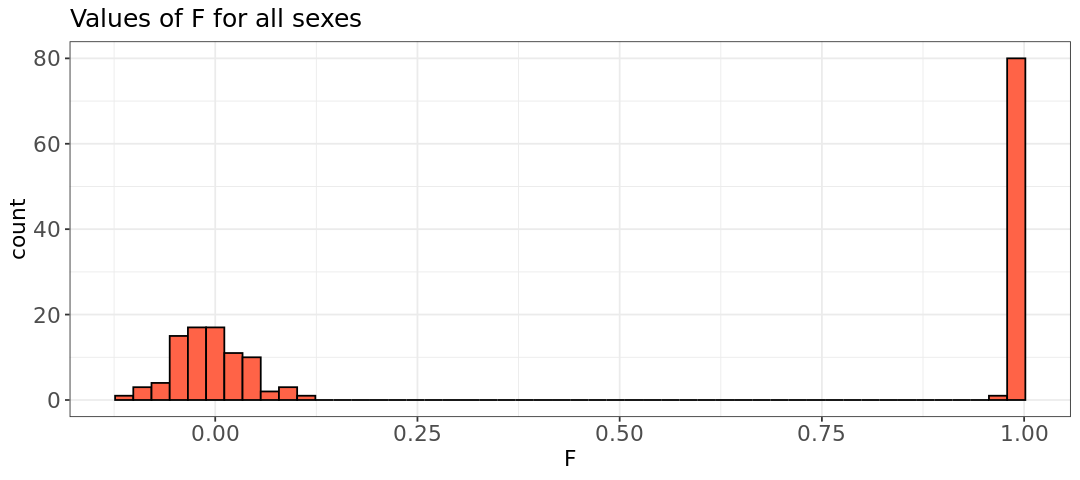

Saving 6.67 x 6.67 in image
Saving 6.67 x 6.67 in image

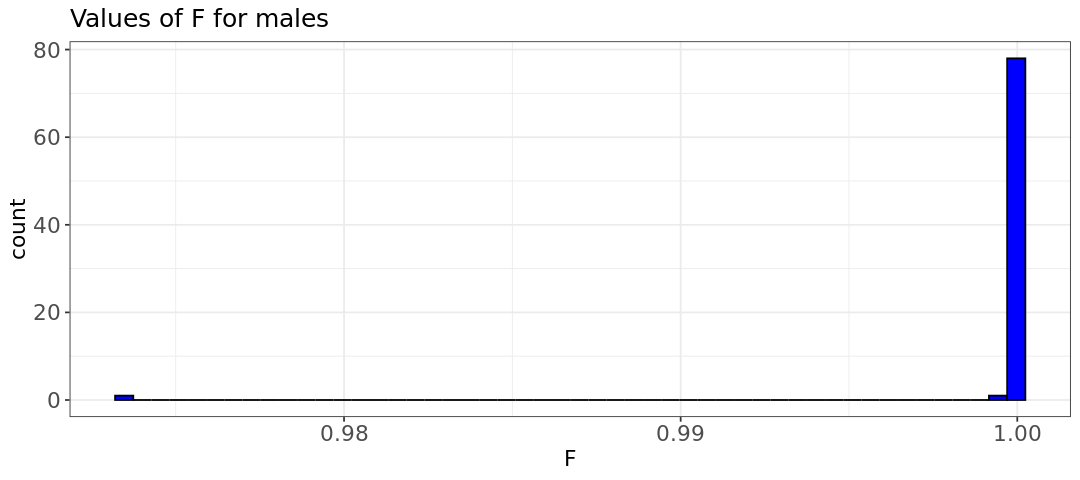

In [1]:
# Inbreeding coefficients for all sexes and for males/females separately
suppressMessages(suppressWarnings(library(ggplot2)))
options(repr.plot.width = 9, repr.plot.height = 4)

# Read data into R and subset for sexes
sex <- read.table("Results/GWAS3/HapMap_3_r3_2.sexcheck", header=T,as.is=T)
male <- subset(sex, sex$PEDSEX==1)

# sex inbreeding coeff histogram
hist.sex <- ggplot(sex, aes(x=sex[,6])) +
  geom_histogram(col = "black", fill="tomato", bins=50) + 
  labs(title = "Values of F for all sexes") + 
  xlab("F") + 
  theme_bw() +
  theme(axis.title=element_text(size=13), axis.text=element_text(size=13), plot.title=element_text(size=15))


# Inbreeding coeff in males histogram
hist.male <- ggplot(male, aes(x=male[,6])) +
  geom_histogram(col = "black", fill="blue", bins=50) + 
  labs(title = "Values of F for males") + 
  xlab("F") + 
  theme_bw() +
  theme(axis.title=element_text(size=13), axis.text=element_text(size=13), plot.title=element_text(size=15))


show(hist.sex)
show(hist.male)

# Save plots 
ggsave(plot=hist.sex, filename="Results/GWAS3/histsex.png")
ggsave(plot=hist.male, filename="Results/GWAS3/histmale.png")


> **Stop - Read - Solve**
>
> -   1.  Do the plots look as you would expect?
> -   1.  Modify the code above to plot the F values for females and
>         save the plot as `Results/GWAS3/histfemale.png`
> -   1.  What can you conclude about the distribution of inbreeding
>         coefficients between males and females? (pay attention to the
>         axis ranges)

In [ ]:
# Write your code here - female F values histogram 

> **Solution**
>
> 1.  Yes.
>
> 2.  You need to change the value `sex$PEDSEX==2` instead of `==1` in
>     the code for the histogram, and change the file name at the end
>
> ``` bash
> # B) 
>
> # subset females 
> female <- subset(sex, sex$PEDSEX==2)
>
> # Inbreeding coeff in females histogram
> hist.female <- ggplot(female, aes(x=female[,6])) +
>   geom_histogram(col = "black", fill="blue", bins=50) + 
>   labs(title = "Values of F for females") + 
>   xlab("F") + 
>   theme_bw() +
>   theme(axis.title=element_text(size=13), axis.text=element_text(size=13), plot.title=element_text(size=15))
>
> # Show hist
> show(hist.female)
>
> # Save plot 
> ggsave(plot=hist.female, filename="Results/GWAS3/histfemale.png")
> ```
>
>     Saving 6.67 x 6.67 in image
>
> 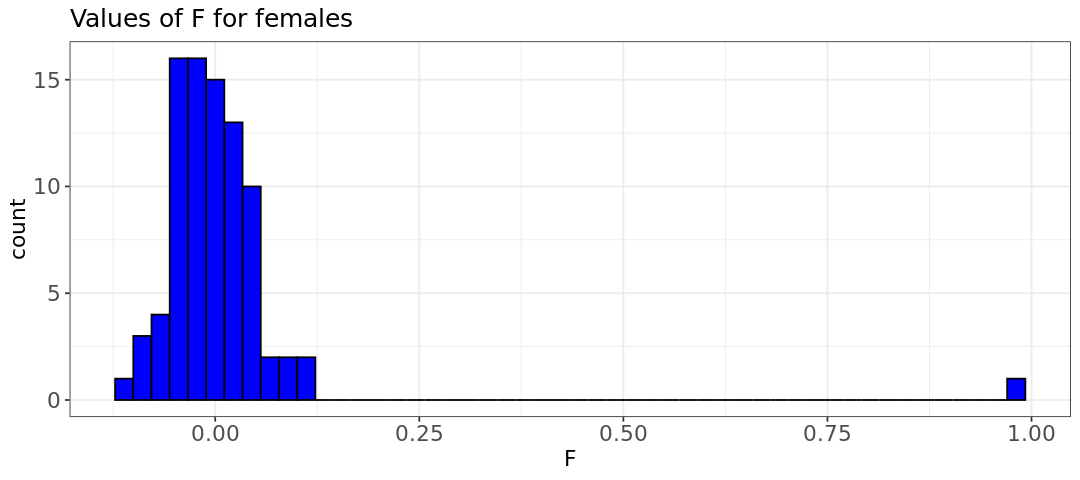
>
> 1.  The inbreeding coefficient plot indicates that there is one woman
>     with a sex discrepancy (F value of 0.99). When using other
>     datasets often a few discrepancies might be found.

------------------------------------------------------------------------

### How can we proceed?

We have two options when dealing with sex discrepancy. One is to simply
remove any individual with sex discrepancy. In our case, this would
involve removing the female with the F value of 0.99.

<img src="Images/bash.png" alt="bash" width="40"> Switch to the Bash
kernel.

Removal can be done with the command below. Use `grep` to find lines in
the sexcheck file that contain `PROBLEM`. Then, pipe (send) the output
to the command `awk` (using the so-called pipe symbol `|`). `awk` will
extract the first two columns from each line identified by the `grep`
command and redirect them to the file `sex_discrepancy.txt` using the
symbol `>` (redirecting the output away from the screen/terminal).

In [1]:
grep "PROBLEM" Results/GWAS3/HapMap_3_r3_2.sexcheck | awk '{print$1,$2}' > Results/GWAS3/sex_discrepancy.txt

Show the content of the file using `cat`:

In [2]:
cat Results/GWAS3/sex_discrepancy.txt

1349 NA10854

For long files, you can simply count the number of lines in the file
with `wc` (word count command)

In [3]:
wc -l Results/GWAS3/sex_discrepancy.txt

1 Results/GWAS3/sex_discrepancy.txt

The file can be provided to PLINK for removal of sex-discrepant
individuals using the option `--remove`:

In [4]:
plink --bfile Results/GWAS3/HapMap_3_r3_2 \
    --remove Results/GWAS3/sex_discrepancy.txt \
    --make-bed --out Results/GWAS3/HapMap_3_r3_3 \
    --silent

); many commands treat these as missing.

> **Alternative approach**
>
> The other approach supported by PLINK is to impute the sex codes based
> on the SNP data, which is done with the command `--impute-sex` as
> shown below.
>
> ``` {bash}
> plink --bfile Results/GWAS3/HapMap_3_r3_2 --impute-sex --make-bed --out Results/GWAS3/HapMap_3_r3_3_alt
> ```
>
> PLINK automatically detects and imputes incorrect sex information,
> requiring just an additional option to be specified. However, we will
> not be executing this command. Instead, we will retain only the
> dataset where incorrect sexes have already been filtered out:
> `Results/GWAS3/HapMap_3_r3_3`.

# Minor Allele Frequency (MAF)

Excluding SNPs based on minor allele frequency (MAF) is somewhat
controversial. In a sense, it has little to do with quality control –
there is no reason to think there are any errors in the data. The main
justification is statistical:

-   If MAF is low, and the SNP is rare, then the power is low
    (i.e. don’t spend multiple testing corrections on tests that are
    unlikely to find anything anyway).
-   Some statistical methods perform badly with low MAF (e.g. the
    chi-squared-test).

An appropriate cutoff definitely depends on sample size – the larger the
sample, the greater your ability to include rare SNPs. Typically,
researchers utilize thresholds of 0.1 or 0.05 (Kanaka et al. 2023).

## PLINK commands

Filtering data based on the minor allele frequencies is done in a
similar way to previous commands. If you want to get rid only of the
fixed SNPs, you specify a MAF threshold of 0, which can be done by the
command `--maf 0`.

> **Warning**
>
> One should **limit MAF analysis to only autosomal chromosomes**,
> meaning you need to generate a subset of the data containing only
> autosomal chromosomes as done below.

First, we extract the SNP identifiers from chromosomes 1 to 22 with
`awk`, and redirect the output to the file `snp_1_22.txt`. Then, PLINK
can extract those SNPs using the option `--extract`:

In [5]:
# Get a file with autosomal variants
awk '{ if ($1 >= 1 && $1 <= 22) print $2 }' Results/GWAS3/HapMap_3_r3_3.bim > Results/GWAS3/snp_1_22.txt
# Filter data based on the list of SNPs
plink --bfile Results/GWAS3/HapMap_3_r3_3 \
    --extract Results/GWAS3/snp_1_22.txt \
    --make-bed \
    --out Results/GWAS3/HapMap_3_r3_4 \
    --silent

> **Stop - Read - Solve**
>
> How can you verify if only the autosomal regions are present in the
> output? Retrieve a list of chromosomes present in one of the files
> with the prefix `Results/GWAS3/HapMap_3_r3_4`.

In [9]:
# write your code

> **Solution**
>
> SNPs are saved in the output `bim` file and the first column contains
> the chromosome names. So, we just need to extract the first column,
> and check the unique names (as extra, we count how many times each
> chromosome occurs):
>
> ``` bash
> cut -f 1 Results/GWAS3/HapMap_3_r3_4.bim | uniq -c
> ```
>
>      117459 1
>      117501 2
>       97341 3
>       86388 4
>       88819 5
>       92037 6
>       75919 7
>       75777 8
>       64180 9
>       74379 10
>       71812 11
>       68941 12
>       52335 13
>       45626 14
>       42284 15
>       45090 16
>       38729 17
>       41141 18
>       26437 19
>       36624 20
>       19415 21
>       20310 22
>
> You can do exactly the same with `awk`
>
> ``` bash
> awk '{print$1}' Results/GWAS3/HapMap_3_r3_4.bim | uniq -c
> ```
>
>      117459 1
>      117501 2
>       97341 3
>       86388 4
>       88819 5
>       92037 6
>       75919 7
>       75777 8
>       64180 9
>       74379 10
>       71812 11
>       68941 12
>       52335 13
>       45626 14
>       42284 15
>       45090 16
>       38729 17
>       41141 18
>       26437 19
>       36624 20
>       19415 21
>       20310 22

------------------------------------------------------------------------

Now that we have a set of files containing only autosomal chromosomes,
let’s obtain summary statistics for the minor allele frequency and plot
the values on a histogram. This can be done using the `--freq` option in
PLINK.

> **Stop - Read - Solve**
>
> **Try to write the PLINK command below before reviewing the command
> provided.**
>
> Hint: Remember most PLINK commands are written in this basic form:
>
>     plink --bfile INPUT --out OUTPUT
>
> with the additional option `--make-bed` if you need to generate a
> modified version of the data. Now you want to calculate the `MAF` of
> the data, so `--make-bed` is not needed, but you need the option
> `--freq` to calculate frequencies from the INPUT. You will need to
> give a name for the output containing the frequencies. Use the INPUT
> `Results/GWAS3/HapMap_3_r3_4` (the last data in use) and the OUTPUT
> `Results/GWAS3/MAF_check`.

In [1]:
# Your PLINK command

> **Solution**
>
> Here the correct command. Check if it matches yours (the `--silent`
> option is to avoid long outputs on the screen, but has no effect on
> data)
>
> ``` bash
> # Generate a plot of the MAF distribution.
> plink --bfile Results/GWAS3/HapMap_3_r3_4 --freq --out Results/GWAS3/MAF_check --silent
> ```

------------------------------------------------------------------------

<img src="Images/R.png" alt="R" width="40"> Switch to the R kernel.

Let’s plot the MAF histogram using `R`. We will have a second plot,
which is a zoom-in version with MAF up to 0.1 to better observe the low
MAF values. Note: The zoom-in version will throw some warnings as data
points are removed, but don’t worry about it.

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.00000 0.05856 0.18750 0.20315 0.33480 0.50000 

Warning message:
“Removed 929441 rows containing non-finite outside the scale range
(`stat_bin()`).”
Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_bar()`).”

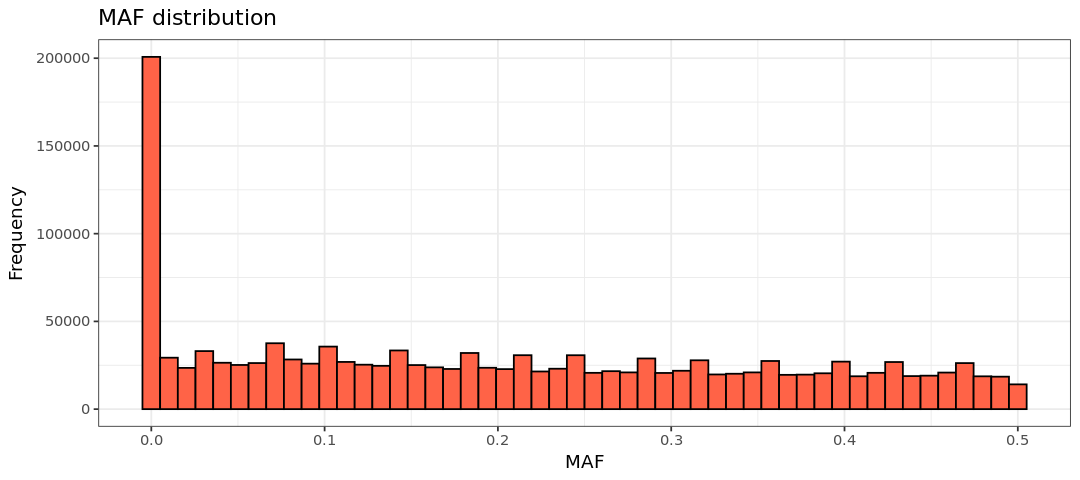

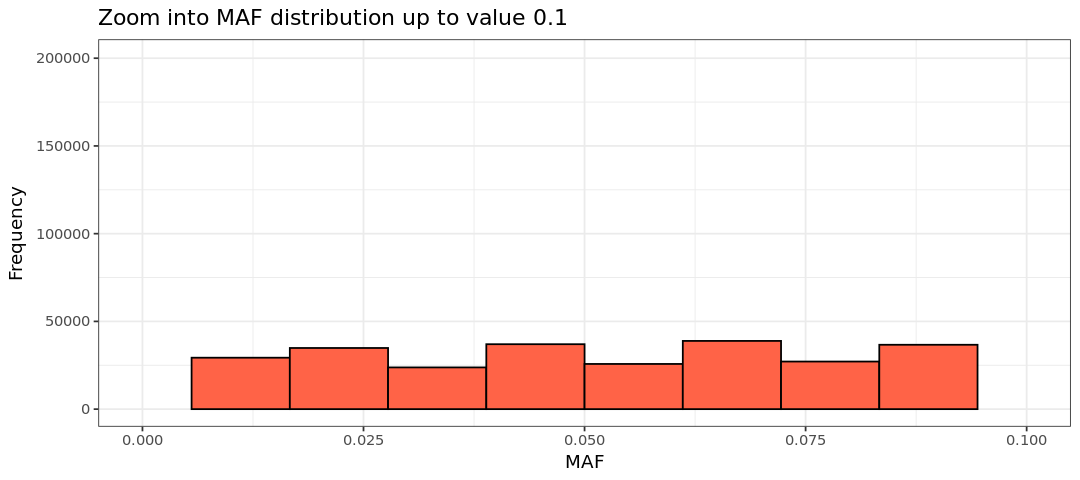

In [1]:
# MAF plot only for autosomal SNPs. Note the zoomed interval (0,0.1)
suppressMessages(suppressWarnings(library(ggplot2)))
options(repr.plot.width = 9, repr.plot.height = 4)

# Read data into R 
maf_freq <- read.table("Results/GWAS3/MAF_check.frq", header =TRUE, as.is=T)

summary(maf_freq$MAF)

# maf_freq histogram
hist.maf <- ggplot(maf_freq, aes(x=maf_freq[,5])) +
  geom_histogram(col = "black", fill="tomato", bins=50) + 
  labs(title = "MAF distribution") + 
  xlab("MAF") + 
  ylab("Frequency") +
  theme_bw()

# zoom-in into X-axis
hist.maf.zoom <- ggplot(maf_freq, aes(x=maf_freq[,5])) +
  geom_histogram(col = "black", fill="tomato", bins = 10) + 
  labs(title = "Zoom into MAF distribution up to value 0.1") + 
  xlab("MAF") + 
  ylab("Frequency") +
  xlim(0, 0.1) +
  theme_bw()


show(hist.maf)
show(hist.maf.zoom)

# Save plot
suppressMessages(ggsave(plot=hist.maf, filename="Results/GWAS3/histmaf.png"))

<img src="Images/bash.png" alt="bash" width="40"> Switch to the Bash
kernel.

As stated above, your MAF threshold depends on sample size, though a
conventional MAF threshold for a regular GWAS is between 0.01 and 0.05.
Here, to ensure the inclusion of only SNPs we will apply a MAF threshold
of 0.05 (that is, remove SNPs where the MAF is 5% or less). The
threshold is given with the option `--maf`:

In [2]:
# Remove SNPs with a low MAF frequency.
plink --bfile Results/GWAS3/HapMap_3_r3_4 \
    --maf 0.05 \
    --make-bed \
    --out Results/GWAS3/HapMap_3_r3_5 \
    --silent

> **Stop - Read - Solve**
>
> -   **Determine the number of SNPs remaining after applying quality
>     control measures.** Hint: Check the `.bim` file from the output
>     with the prefix `Results/GWAS3/HapMap_3_r3_5`.
> -   **Repeat the process for a MAF threshold of 0.01. How many
>     additional SNPs would be retrieved?** Do not overwrite the output
>     from the command above! Please, rename the output prefix
>     (e.g. `Results/GWAS3/HapMap_3_r3_5_alt`)

In [ ]:
# Write your code here - maf > 0.05

In [ ]:
# Write your code here - maf > 0.01

> **Solution**
>
> Check the number of lines of the `.bim` file using `wc -l` and modify
> the plink command from above:
>
> ``` bash
> wc -l Results/GWAS3/HapMap_3_r3_5.bim
> ```
>
>     1073226 Results/GWAS3/HapMap_3_r3_5.bim
>
> ``` bash
> # plink filtering step
> plink --bfile Results/GWAS3/HapMap_3_r3_4 \
>     --maf 0.01 \
>     --make-bed \
>     --out Results/GWAS3/HapMap_3_r3_5_alt \
>     --silent
>     
> # get number of variants
> wc -l Results/GWAS3/HapMap_3_r3_5_alt.bim
> ```
>
>     1181555 Results/GWAS3/HapMap_3_r3_5_alt.bim
>
> The difference between the two threshold is ~100,000 SNPS

------------------------------------------------------------------------

It is worth noting that no matter what the sample size is, monomorphic
SNPs (i.e., SNPs that show no genetic variation whatsoever in the
sample) are usually problematic and should always be removed. Some code
crashes when monomorphic SNPs are included; even if this wasn’t the
case, these SNPs cannot possibly be informative in a genome-wide
association study.

# Hardy-Weinberg Equilibrium (HWE)

The Hardy-Weinberg rule from population genetics states that genetic
variation (thus, allele and genotype frequencies) in a population will
remain constant unless certain disturbing factors are introduced. his
implies that once we know the allele frequencies for $p$ and $q$, the
genotype frequencies will be defined as $p^2$, $2pq$, and $q^2$.

Let’s say the frequency of allele A ($p$ in the equation) is 0.4, and
that of allele B ($q$) is 0.6. This means for the H-W scenario the
genotype frequencies will be 0.16 for AA, 0.48 for AB, and 0.36 for BB.
In a population of e.g. 1000 individuals with the mentioned allele
frequencies we expect to see 160 AA, 480 AB, and 360 BB individuals. Of
course, we rarely see exact H-W distributions in real populations. The
question then becomes, what is the difference between the expected H-W
and observed proportions? There are typically two reasons why a SNP is
not in HWE:

-   Genotyping error for this SNP
-   Mating is not random

In reality, mating is not random, which complicates excluding SNPs based
on HWE. It is generally recommended to exclude an SNP only when HWE is
significantly violated, such as when the p-value for a statistical test
(e.g., assessing whether the data follow a binomial distribution) is
extremely low, like p-value p\<10e−10

> **HWE and binomial distribution**
>
> **Why is HWE connected to the binomial distribution? What is the
> ground theory behind HWE?**
>
> You can find a clear explanation of HWE at (Lachance 2016).

## PLINK commands

We can use the option `--hardy` in PLINK to generate H-W p-values (as
well as observed and expected heterozygosity). Then, use `awk` to select
SNPs (column 9 of the file) with HWE p-value \< 0.0001, indicating a
strong deviation from HWE.

In [1]:
plink --bfile Results/GWAS3/HapMap_3_r3_5 --hardy --out Results/GWAS3/HapMap_3_r3_5 --silent

awk '{ if ($9 <0.00001) print $0 }' Results/GWAS3/HapMap_3_r3_5.hwe > Results/GWAS3/HapMap_3_r3_5.deviating.hwe

**What can we conclude about the data from the generated files?**

<img src="Images/R.png" alt="R" width="40"> Switch to the R kernel.

Let’s plot a histogram of the HWE p-values and zoom in for the deviating
p-values. To do this, we need to read the PLINK output and examine the
table with the low HWE p-values. The header of the PLINK output includes
the following fields:

-   `CHR`: Chromosome number.
-   `SNP`: SNP identifier (rsID).
-   `TEST`: Type of HWE test performed. This will usually be “UNAFF” for
    the test on controls if your data has case/control status.
-   `A1`: First allele (reference allele).
-   `A2`: Second allele (alternate allele).
-   `GENO`: Genotype counts in the format “HOM1/HET/HOM2”, where HOM1 is
    the count of homozygous for the first allele, HET is the count of
    heterozygous, and HOM2 is the - count of homozygous for the second
    allele.
-   `O(HET)`: Observed heterozygote frequency.
-   `E(HET)`: Expected heterozygote frequency.
-   `P`: Hardy-Weinberg equilibrium exact test p-value.

We will modify the values in the `TEST` column to have more readable
names for the plots and save the updated values in the `Phenotype`
column.

In [1]:
# HWE tables
suppressMessages(suppressWarnings(library(dplyr)))

# Read data into R using dplyr library 
hwe <- read.table(file="Results/GWAS3/HapMap_3_r3_5.hwe", header=TRUE)
hwe_zoom <- read.table(file="Results/GWAS3/HapMap_3_r3_5.deviating.hwe", header=FALSE)
# Add column names 
colnames(hwe_zoom) <- colnames(hwe)
# Modify colnames 
hwe$Phenotype <- recode(hwe$TEST, "ALL"="All", "UNAFF"="Control", "AFF"="Non-Control")
hwe_zoom$Phenotype <- recode(hwe_zoom$TEST, "ALL"="All", "UNAFF"="Control", "AFF"="Non-Control")

Here, we print the first rows of the two generated tables

In [2]:
head(hwe)
head(hwe_zoom)

Now, we can plot the histograms. We isolate each “phenotype” to see if
there are any significant differences in p-value distribution between
them.

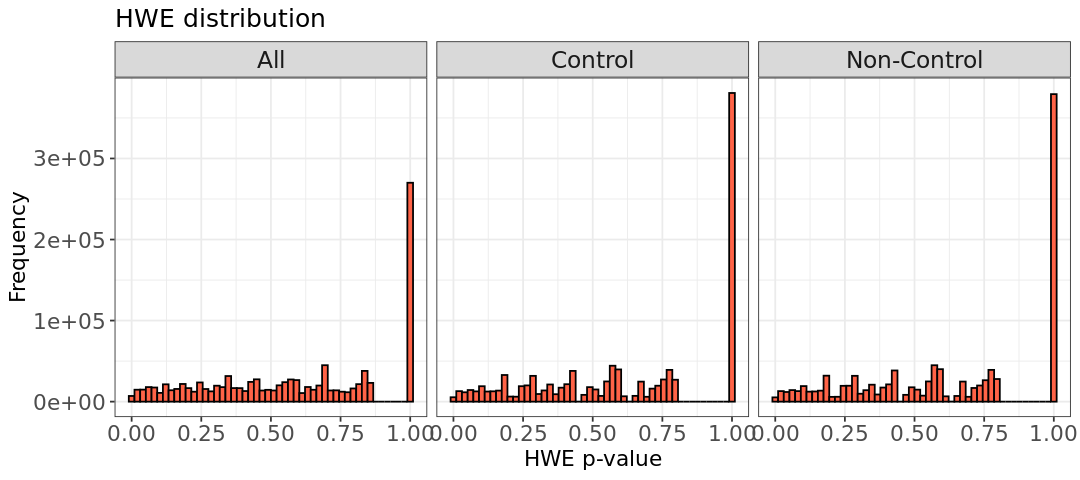

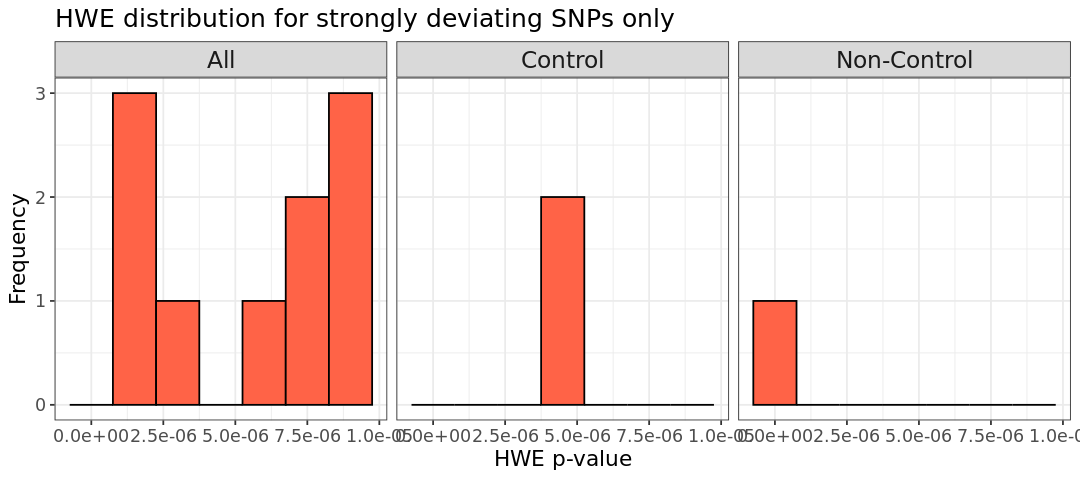

In [3]:
# HWE p-values calculated with PLINK and zoom for the SNPs deviating from HWE. We can spot some deviations from HWE in the zoomed plot. Note that the p+values for the phenotype `All` is not the merging of the barplots from the other two phenotypes!
suppressMessages(suppressWarnings(library(ggplot2)))
options(repr.plot.width = 9, repr.plot.height = 4)

# maf_freq histogram
hist.hwe <- ggplot(hwe, aes(x=hwe[,9])) +
  geom_histogram(col = "black", fill="tomato", bins=50) + 
  labs(title = "HWE distribution") + 
  xlab("HWE p-value") + 
  ylab("Frequency") +
  facet_wrap(~Phenotype) +
  theme_bw() + 
  theme(axis.title=element_text(size=13), axis.text=element_text(size=13), plot.title=element_text(size=15),strip.text = element_text(size = 14))

# maf_freq histogram
hist.hwe_below_threshold <- ggplot(hwe_zoom, aes(x=hwe_zoom[,9])) +
  geom_histogram(binwidth = 0.0000015, col = "black", fill="tomato") + 
  labs(title = "HWE distribution for strongly deviating SNPs only") + 
  xlab("HWE p-value") + 
  ylab("Frequency") +
  facet_wrap(~Phenotype) +
  theme_bw() +
  theme(axis.title=element_text(size=13), axis.text=element_text(size=10.5), plot.title=element_text(size=15),strip.text = element_text(size = 14))

show(hist.hwe)
show(hist.hwe_below_threshold)

# Save plots 
suppressMessages({
ggsave(plot=hist.hwe, filename="Results/GWAS3/histhwe.png");
ggsave(plot=hist.hwe_below_threshold, filename="Results/GWAS3/histhwe_below_threshold.png");})

<img src="Images/bash.png" alt="bash" width="40"> Switch to the Bash
kernel.

Almost all of our SNPs are in HWE, as determined by testing whether the
alleles follow a binomial distribution. However, in our zoomed-in plot,
we can spot a few extreme deviations. We can remove these outliers using
the option `--hwe` in PLINK with the specified threshold. Note that
`--hwe` filters only on controls, so if you want to apply the threshold
to non-controls as well, add the `include-nonctrl` in the command. In
the first step below, we filter controls using a threshold of `1e-6`,
followed by filtering all phenotypes with a threshold `1e-10`:

In [1]:
# filter applied to controls 
plink --bfile Results/GWAS3/HapMap_3_r3_5 --hwe 1e-6 --make-bed --out Results/GWAS3/HapMap_3_r3_5_onlycontrols

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWAS3/HapMap_3_r3_5_onlycontrols.log.
Options in effect:
  --bfile Results/GWAS3/HapMap_3_r3_5
  --hwe 1e-6
  --make-bed
  --out Results/GWAS3/HapMap_3_r3_5_onlycontrols

385567 MB RAM detected; reserving 192783 MB for main workspace.
1073226 variants loaded from .bim file.
164 people (80 males, 84 females) loaded from .fam.
112 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 112 founders and 52 nonfounders present.
Calculating allele frequencies... done.
Total genotyping rate is 0.998039.
--hwe: 0 variants removed due to Hardy-Weinberg exact test.
1073226 variants and 164 people pass filters and QC.
Among remaining phenotypes, 56 are cases and 56 are controls.  (52 phenotypes
are missing.)
--make-bed to Results/GWAS3/HapMap_3_r3_5_onlycontr

In [2]:
# threshold apply to all ind
plink --bfile Results/GWAS3/HapMap_3_r3_5_onlycontrols --hwe 1e-10 include-nonctrl --make-bed --out Results/GWAS3/HapMap_3_r3_6

PLINK v1.90b6.21 64-bit (19 Oct 2020)          www.cog-genomics.org/plink/1.9/
(C) 2005-2020 Shaun Purcell, Christopher Chang   GNU General Public License v3
Logging to Results/GWAS3/HapMap_3_r3_6.log.
Options in effect:
  --bfile Results/GWAS3/HapMap_3_r3_5_onlycontrols
  --hwe 1e-10 include-nonctrl
  --make-bed
  --out Results/GWAS3/HapMap_3_r3_6

385567 MB RAM detected; reserving 192783 MB for main workspace.
1073226 variants loaded from .bim file.
164 people (80 males, 84 females) loaded from .fam.
112 phenotype values loaded from .fam.
Using 1 thread (no multithreaded calculations invoked).
Before main variant filters, 112 founders and 52 nonfounders present.
Calculating allele frequencies... done.
Total genotyping rate is 0.998039.
--hwe: 0 variants removed due to Hardy-Weinberg exact test.
1073226 variants and 164 people pass filters and QC.
Among remaining phenotypes, 56 are cases and 56 are controls.  (52 phenotypes
are missing.)
--make-bed to Results/GWAS3/HapMap_3_r3_6.bed +

This was just an example to show the commands, but you can notice how
the filter removed 0 variants.

> **Note**
>
> **Why using a softer filtering threshold for HWE?** HWE test assumes
> that the population is **randomly mating without strong selection,
> migration, or genotyping errors**. Since cases may be under selective
> pressure due to the disease, they may deviate from HWE due to
> association with the phenotype rather than genotyping errors or
> population structure.
>
> Thus it is better to choose a lower threshold for cases, or avoiding
> filtering them at all according to HWE.

# Heterozygosity Rate

We filter individuals based on their heterozygosity rate, which is
similar to HWE but applied at the individual level. If an individual has
an unusually high number of heterozygous calls (A/B) and no homozygous
calls (A/A or B/B), or vice versa, it could indicate data issues.

## PLINK commands

PLINK does not provide a summary of individual heterozygosity. To assess
this, we first prune the dataset by excluding highly correlated SNPs, as
they reduce analysis power. We use
`--indep-pairwise <window size>['kb'] <step size (variant ct)> <r^2 threshold>`
to prune SNPs in high Linkage Disequilibrium, excluding high inversion
regions (`--exclude` with `Data/inversion.txt`). For more information,
click [here](https://www.cog-genomics.org/plink/1.9/ld).

In our case, the parameters for the `--indep-pairwise` are `50 5 0.2`
representing the window size, shift-window step count, and correlation
threshold for pruning. Once we have the pruned list, we will check
heterozygosity on the **set of SNPs that are not highly correlated**.

In [3]:
plink --bfile Results/GWAS3/HapMap_3_r3_6 \
    --exclude Data/inversion.txt \
    --range \
    --indep-pairwise 50 5 0.2 \
    --out Results/GWAS3/indepSNP \
    --silent

With this pruned list, we measure the heterozygosity rates of the
individuals in the remaining independent SNPs.

In [4]:
plink --bfile Results/GWAS3/HapMap_3_r3_6 \
    --extract Results/GWAS3/indepSNP.prune.in \
    --het \
    --out Results/GWAS3/R_check \
    --silent

<img src="Images/R.png" alt="R" width="40"> Switch to the R kernel.

Now, let’s plot the distribution of heterozygosity rates. Again, we will
first examine the heterozygosity table. The `--het` option in PLINK
generates an output table with the following columns:

-   `FID`: Individual’s Family ID.
-   `IID`: Individual ID within the family.
-   `O(HOM)`: Observed number of homozygous genotypes.
-   `E(HOM)`: Expected number of homozygous genotypes under
    Hardy-Weinberg equilibrium.
-   `N(NM)`: Number of non-missing autosomal genotypes.
-   `F`: Inbreeding coefficient, which is calculated as
    $\tfrac{(E(HOM)−O(HOM))}{N(NM)}$.

In [1]:
het <- read.table("Results/GWAS3/R_check.het", head=TRUE)
head(het)

We will calculate the heterozygosity rates manually for plotting, as
they are not included by default in the table. The formula is
$N(NM)-O(HOM)/N(NM)$

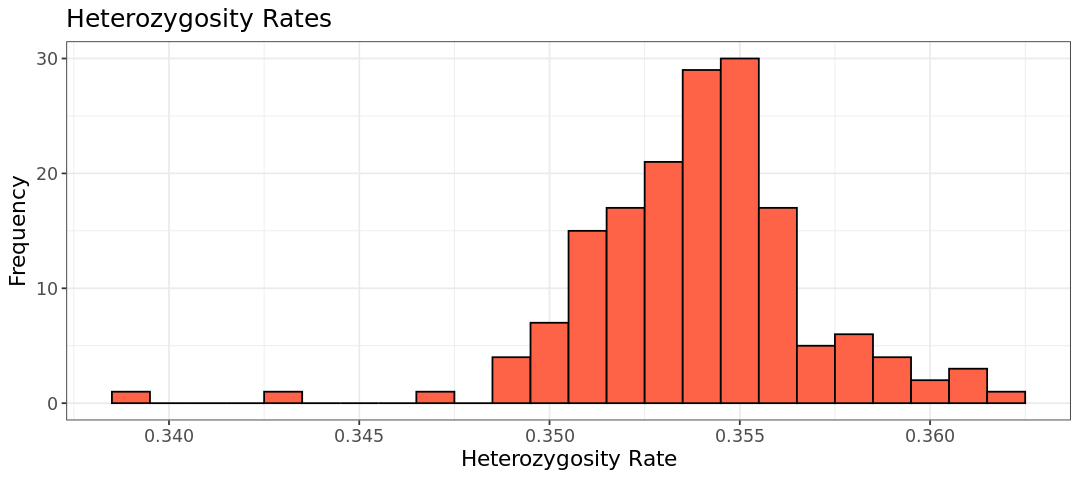

In [2]:
# Barplot for heterozigosity rates
suppressMessages(suppressWarnings(library(ggplot2)))
options(repr.plot.width = 9, repr.plot.height = 4)

het$HET_RATE = (het$"N.NM." - het$"O.HOM.")/het$"N.NM."

# plink.imiss histogram
hist.het <- ggplot(het, aes(x=HET_RATE)) +
  geom_histogram(binwidth = 0.001, col = "black", fill="tomato") + 
  labs(title = "Heterozygosity Rates") + 
  xlab("Heterozygosity Rate") + 
  ylab("Frequency") + 
  theme_bw() +
  theme(axis.title=element_text(size=13), axis.text=element_text(size=10.5), plot.title=element_text(size=15))


show(hist.het)

# Save plots 
suppressMessages(ggsave(plot=hist.het, filename="Results/GWAS3/heterozygosity.png"))

As a rule of thumb, **we remove individuals whose heterozygosity
deviates (sd) more than 3 standard deviations from the mean**. We will
create a file that subsets the heterozygosity table based on this
threshold for use in PLINK removal. Additionally, we’ll add a `HET_DST`
column to the table containing the standardized heterozygosity values.

In [3]:
suppressMessages(suppressWarnings(library(dplyr)))

# read file 
het <- read.table("Results/GWAS3/R_check.het", head=TRUE)
# add column with heterozygocity rates
het$HET_RATE = (het$"N.NM." - het$"O.HOM.")/het$"N.NM."

# Substract inds that deviate more than sd=3 from the mean 
het_fail <- subset(het, (het$HET_RATE < mean(het$HET_RATE)-3*sd(het$HET_RATE)) | 
                    (het$HET_RATE > mean(het$HET_RATE)+3*sd(het$HET_RATE)))

# Add column with standardized heterozygosity rates
het_fail$HET_DST <- (het_fail$HET_RATE-mean(het$HET_RATE))/sd(het$HET_RATE)

# write file 
write.table(het_fail, "Results/GWAS3/fail-het-qc.txt", row.names=FALSE, quote=FALSE)

> **Stop - Read - Solve**
>
> The output of the R code is saved as `fail-het-qc.txt`. Let’s check
> how many individuals are picked up as having a heterozygosity rate
> deviating more than 3 SDs from the mean.
>
> Hint: `wc -l` counts only the lines in the file (incl. header).
>
> <img src="Images/bash.png" alt="bash" width="40"> Switch to the Bash
> kernel.

In [ ]:
#Write your code here

> **Solution**
>
> We can count 3 lines (one is the header), meaning there are two
> individuals to be filtered out. To use the file in PLINK, we need only
> the first two columns (Family ID and Individual ID) as shown below
>
> ``` bash
> wc -l Results/GWAS3/fail-het-qc.txt
> ```
>
>     3 Results/GWAS3/fail-het-qc.txt
>
> We need the first two columns to create the list of individuals to
> remove.
>
> ``` bash
> cat Results/GWAS3/fail-het-qc.txt
> ```
>
>     FID IID O.HOM. E.HOM. N.NM. F HET_RATE HET_DST
>     1330 NA12342 68049 67240 103571 0.02229 0.342972453679119 -3.66711854374478
>     1459 NA12874 68802 67560 104068 0.0339 0.338874582004074 -5.04839854982741
>
> We use `awk` to print out the first two columns in the file
> `het-fail-ind.txt` and the option `--remove` to filter out the
> individuals using PLINK.
>
> ``` bash
> awk '{print$1, $2}' Results/GWAS3/fail-het-qc.txt > Results/GWAS3/het-fail-ind.txt
>
> plink --bfile Results/GWAS3/HapMap_3_r3_6 \
>     --remove Results/GWAS3/het-fail-ind.txt \
>     --make-bed \
>     --out Results/GWAS3/HapMap_3_r3_7 \
>     --silent
> ```
>
> After all filtering is done, we can count the number of individuals
> and variants
>
> ``` bash
> wc -l Results/GWAS3/HapMap_3_r3_7.fam
> wc -l Results/GWAS3/HapMap_3_r3_7.bim
> ```
>
>     162 Results/GWAS3/HapMap_3_r3_7.fam
>     1073226 Results/GWAS3/HapMap_3_r3_7.bim
>
> Look back at the very first run of PLINK. We had 1457897 SNPs and 165
> individuals. We filtered out around 1/3 of all SNPs!

------------------------------------------------------------------------

> **Challenge yourself: first quality control on mice data**
>
> We continue working with the mice data. Now we want to do a quality
> control workflow as we did before. Try to repeat all the steps,
> excluding the sex discrepancies, which cannot be done due to the
> missing sex chromosomes in the data:
>
> 1 - Missingness analysis and filtering, both per SNP and per
> individual.
>
> 2 - Minor Allele Frequency. **Note:** The number of chromosomes is
> different in this dataset.
>
> 3 - Hardy-Weinberg Equilibrium. **Note:** This data contains
> case-control, so you don’t need to rename the columns `hwe$Phenotype`
> and `hwe_zoom$Phenotype`. Similarly, avoid using `include-nonctrl` in
> PLINK. In the R code, you will also want to avoid the line with
> `facet_wrap` separating the group Phenotype for plotting.
>
> 4 - Heterozigosity rate. **Note:** You do not have a list of regions
> with inversions, so do not use `--exclude Data/inversion.txt --range`
> in PLINK.
>
> **General notes for the exercise:**
>
> -   Copy-paste all the commands you need from the tutorial, but
>     remember to carefully check that the file names and options are
>     correct to be used in your data.
> -   Use proper file names for the output of PLINK when filtering and
>     creating new `bed/bim/fam` files. For example, when you apply the
>     various filterings, create a new output name prefix instead of
>     keeping use `mice`. Start from `mice`, then create `mice_miss`,
>     `mice_miss_maf`, `mice_miss_maf_hwe`, `mice_miss_maf_hwe_het`, so
>     that you can trace back all your work to each analysis step.
> -   Feel free to play with the code for creating plots (e.g. changing
>     colors and cutoff values).
> -   Make use of Generative AI to get help for the code if you think it
>     is not enough to use what is provided in the tutorial, or if you
>     want to explore something beyond the exercise.

> **Click to view answers**
>
> <i class="bi bi-journal-code"></i>
> [mice-solutions.ipynb](exercises/gwas3-mice.ipynb)

> **Wrapping up**
>
> In this tutorial, we have tried several quality control approaches in
> PLINK and calculated various statistics, which we visualized using
> `R`. In the next notebook, you will find even more examples of how you
> verify the quality of your data.
>
> A table with a small recap of the options used in filtering with PLINK
>
> | Step | Command | Function | Thresholds and explanation |
> |------------------|------------------|------------------|------------------|
> | 1: Missingness of SNPs | `--geno` | Excludes SNPs that are missing in a large proportion of the subjects. In this step, SNPs with low genotype calls are removed | We recommend first filtering SNPs and individuals based on a relaxed threshold (0.2; \>20%), as this will filter out SNPs and individuals with very high levels of missingness. Then a filter with a more stringent threshold can be applied (0.02) |
> | 2: Missingness of individuals | `--mind` | Excludes individuals who have high rates of genotype missingness. In this step, individuals with low genotype calls are removed | Note, SNP filtering should be performed before individual filtering |
> | 3: Sex discrepancy | `--check-sex` | Checks for discrepancies between the sex of the individuals recorded in the dataset and their sex based on X chromosome heterozygosity/homozygosity rates | Can indicate sample mix‐ups. If many subjects have this discrepancy, the data should be checked carefully. Males should have an X chromosome homozygosity estimate \>0.8 and females should have a value \<0.2 |
> | 4: Minor allele frequency (MAF) | `--maf` | Includes only SNPs above the set MAF threshold | SNPs with a low MAF are rare, therefore power is lacking for detecting SNP‐phenotype associations. These SNPs are also more prone to genotyping errors. The MAF threshold should depend on your sample size, larger samples can use lower MAF thresholds. Respectively, for large (N = 100.000) vs. moderate samples (N = 10000), 0.01 and 0.05 are commonly used as MAF thresholds |
> | 5: Hardy-Weinberg equilibrium (HWE) | `--hwe` | Excludes markers which deviate from Hardy–Weinberg equilibrium | Common indicator of genotyping error, may also indicate evolutionary selection. For binary traits, we suggest excluding: HWE p-value \<1e−10 in cases and \<1e−6 in controls. A less strict case threshold avoids discarding disease‐associated SNPs under selection. For quantitative traits, we recommend HWE p-value \<1e‐6. |
> | 6: Heterozygosity | `R` code + `--remove` option in PLINK | Excludes individuals with high or low heterozygosity rates | Deviations can indicate sample contamination and inbreeding. We suggest removing individuals who deviate ±3 SD from the samples’ heterozygosity rate mean |

# Bibliography

Kanaka, K. K., Nidhi Sukhija, Rangasai Chandra Goli, Sanjeev Singh,
Indrajit Ganguly, S. P. Dixit, Aishwarya Dash, and Anoop Anand Malik.
2023. “On the Concepts and Measures of Diversity in the Genomics Era.”
*Current Plant Biology* 33 (January): 100278.
<https://doi.org/10.1016/j.cpb.2023.100278>.

Lachance, J. 2016. “Hardy–Weinberg Equilibrium and Random Mating.” In
*Encyclopedia of Evolutionary Biology*, edited by Richard M. Kliman,
208–11. Oxford: Academic Press.
<https://doi.org/10.1016/B978-0-12-800049-6.00022-6>.